<a href="https://colab.research.google.com/github/giangdip2410/Colab-Notebook/blob/main/Introduction_ML_MNIST_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
cd drive/MyDrive/UTC/Intro_ML_Practice

/content/drive/MyDrive/UTC/Intro_ML_Practice


### Library

In [ ]:
try:
  from pytorch_model_summary import summary
  from torchviz import make_dot
except:
  !pip install torchviz -q
  !pip install pytorch-model-summary -q
  from pytorch_model_summary import summary
  from torchviz import make_dot
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

In [ ]:
#fix seed
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Prepare Data

In [ ]:
#data root folder
ROOT = '.data'

In [ ]:
#normalize data
train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True)
mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255
print(f'Calculated mean: {mean}')
print(f'Calculated std: {std}')

Calculated mean: 0.13066047430038452
Calculated std: 0.30810779333114624


In [ ]:
# transform data
train_transforms = transforms.Compose([
                            transforms.RandomRotation(5, fill=(0,)),
                            transforms.RandomCrop(28, padding=2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[mean], std=[std])
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std])
                                     ])

In [ ]:
#create dataset
train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True,
                            transform=train_transforms)

test_data = datasets.MNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=test_transforms)
#print information data
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 60000
Number of testing examples: 10000


In [ ]:
#plot image 
def plot_images(images):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap='bone')
        ax.axis('off')

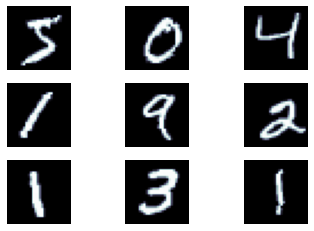

In [ ]:
#sample plot
N_IMAGES = 9

images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]

plot_images(images)

In [ ]:
#valid ratio 
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples
#train val split
train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 48600
Number of validation examples: 5400
Number of testing examples: 10000


In [ ]:
#data loader for train/val/test
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

#Build Deep Learning Model

In [ ]:
# create MLP model
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)

    def forward(self, x):

        # x = [batch size, height, width]

        batch_size = x.shape[0]

        x = x.view(batch_size, -1)

        # x = [batch size, height * width]

        h_1 = F.relu(self.input_fc(x))

        # h_1 = [batch size, 250]

        h_2 = F.relu(self.hidden_fc(h_1))

        # h_2 = [batch size, 100]

        y_pred = self.output_fc(h_2)

        # y_pred = [batch size, output dim]

        return y_pred, h_2

In [ ]:
# create model
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10

model = MLP(INPUT_DIM, OUTPUT_DIM)

In [ ]:
#number of params pytorch model
input_sample =  torch.zeros((1, 1, 28, 28))
print(summary(model, input_sample, show_input=True))

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Linear-1            [1, 784]         196,250         196,250
          Linear-2            [1, 250]          25,100          25,100
          Linear-3            [1, 100]           1,010           1,010
Total params: 222,360
Trainable params: 222,360
Non-trainable params: 0
-----------------------------------------------------------------------


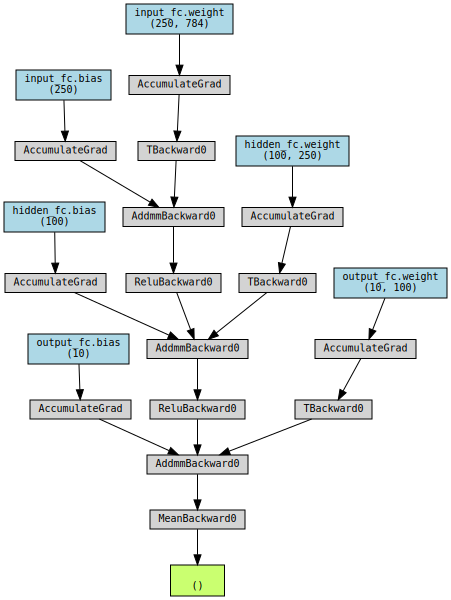

In [ ]:
#visualize model
y = model(input_sample)
make_dot(y[0].mean(), params=dict(model.named_parameters()))

### Training model

In [ ]:
#optimizer
optimizer = optim.Adam(model.parameters())
#loss function
criterion = nn.CrossEntropyLoss()

In [ ]:
#move model to GPU for faster training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
#metric to calculate model performance
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc
#calculate timing
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
#training step function
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
#validate step function
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
# start training
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/760 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 37s
	Train Loss: 0.423 | Train Acc: 86.78%
	 Val. Loss: 0.211 |  Val. Acc: 93.82%


Training:   0%|          | 0/760 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 38s
	Train Loss: 0.183 | Train Acc: 94.35%
	 Val. Loss: 0.160 |  Val. Acc: 94.89%


Training:   0%|          | 0/760 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 35s
	Train Loss: 0.145 | Train Acc: 95.55%
	 Val. Loss: 0.129 |  Val. Acc: 96.16%


Training:   0%|          | 0/760 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 33s
	Train Loss: 0.126 | Train Acc: 96.03%
	 Val. Loss: 0.117 |  Val. Acc: 96.36%


Training:   0%|          | 0/760 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 39s
	Train Loss: 0.112 | Train Acc: 96.51%
	 Val. Loss: 0.117 |  Val. Acc: 96.21%


Training:   0%|          | 0/760 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 37s
	Train Loss: 0.105 | Train Acc: 96.67%
	 Val. Loss: 0.105 |  Val. Acc: 96.73%


Training:   0%|          | 0/760 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 52s
	Train Loss: 0.096 | Train Acc: 97.05%
	 Val. Loss: 0.099 |  Val. Acc: 97.00%


Training:   0%|          | 0/760 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 39s
	Train Loss: 0.088 | Train Acc: 97.24%
	 Val. Loss: 0.090 |  Val. Acc: 97.02%


Training:   0%|          | 0/760 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 49s
	Train Loss: 0.089 | Train Acc: 97.23%
	 Val. Loss: 0.088 |  Val. Acc: 97.26%


Training:   0%|          | 0/760 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 51s
	Train Loss: 0.083 | Train Acc: 97.44%
	 Val. Loss: 0.095 |  Val. Acc: 97.11%


In [ ]:
#save model print model accuracy
model.load_state_dict(torch.load('tut1-model.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.059 | Test Acc: 98.09%


### Diagnostics Model

In [ ]:
#prediction function
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [ ]:
#get predict for test set
images, labels, probs = get_predictions(model, test_iterator, device)

pred_labels = torch.argmax(probs, 1)

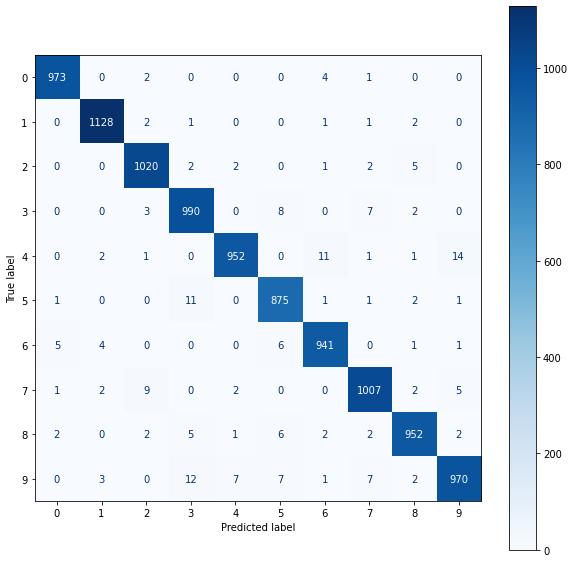

In [ ]:
#plot confusion matrix

def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)
#show plot
plot_confusion_matrix(labels, pred_labels)

In [ ]:
#get uncorrect label
corrects = torch.eq(labels, pred_labels)
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True,
                        key=lambda x: torch.max(x[2], dim=0).values)
#plot uncorrect label
def plot_most_incorrect(incorrect, n_images):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n'
                     f'pred label: {incorrect_label} ({incorrect_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.5)

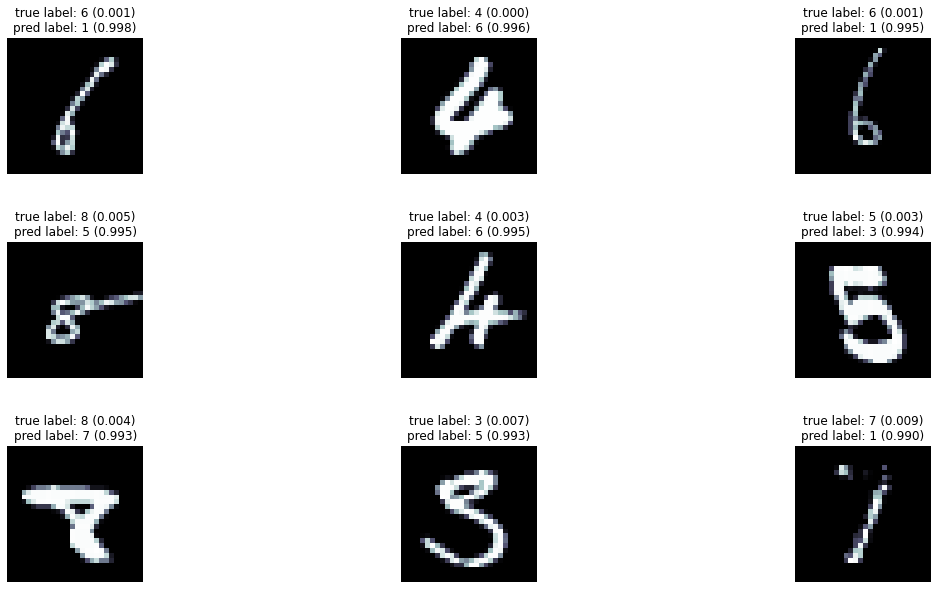

In [ ]:
#show uncorrect image
N_IMAGES = 9

plot_most_incorrect(incorrect_examples, N_IMAGES)

### Deep Learning model representative

In [ ]:
def get_representations(model, iterator, device):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():

        for (x, y) in tqdm(iterator):

            x = x.to(device)

            y_pred, h = model(x)

            outputs.append(y_pred.cpu())
            intermediates.append(h.cpu())
            labels.append(y)

    outputs = torch.cat(outputs, dim=0)
    intermediates = torch.cat(intermediates, dim=0)
    labels = torch.cat(labels, dim=0)

    return outputs, intermediates, labels

In [ ]:
#embedding image
outputs, intermediates, labels = get_representations(model,
                                                     train_iterator,
                                                     device)

  0%|          | 0/760 [00:00<?, ?it/s]

In [ ]:
#pca for visualization
def get_pca(data, n_components=2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data
#plot after pca
def plot_representations(data, labels, n_images=None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10')
    handles, labels = scatter.legend_elements()
    ax.legend(handles=handles, labels=labels)

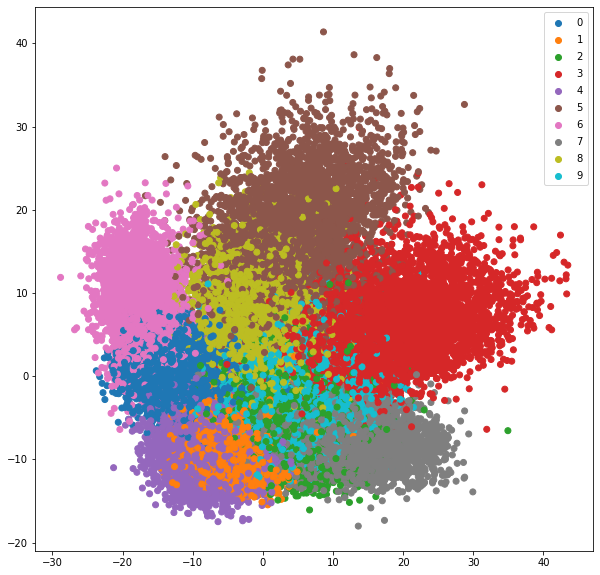

In [ ]:
#show visualize pca
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels)

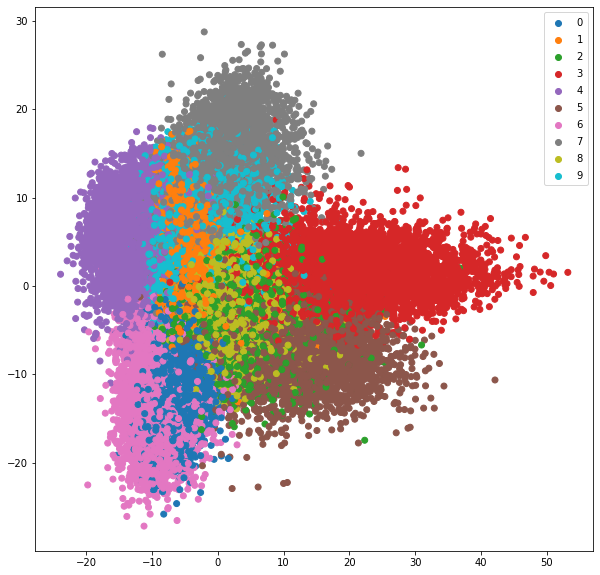

In [ ]:
intermediate_pca_data = get_pca(intermediates)
plot_representations(intermediate_pca_data, labels)

In [ ]:
#An alternative to PCA is t-SNE (t-distributed stochastic neighbor embedding).
def get_tsne(data, n_components=2, n_images=None):
    if n_images is not None:
        data = data[:n_images]
    tsne = manifold.TSNE(n_components=n_components, random_state=0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

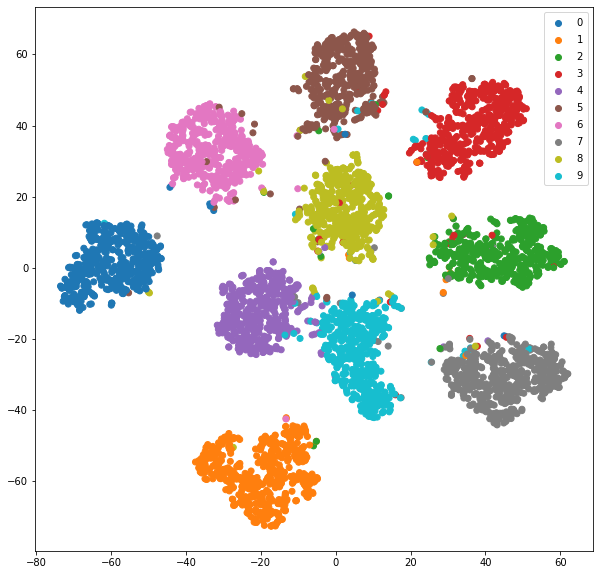

In [ ]:
N_IMAGES = 50

output_tsne_data = get_tsne(outputs, n_images=N_IMAGES)
plot_representations(output_tsne_data, labels, n_images=N_IMAGES)

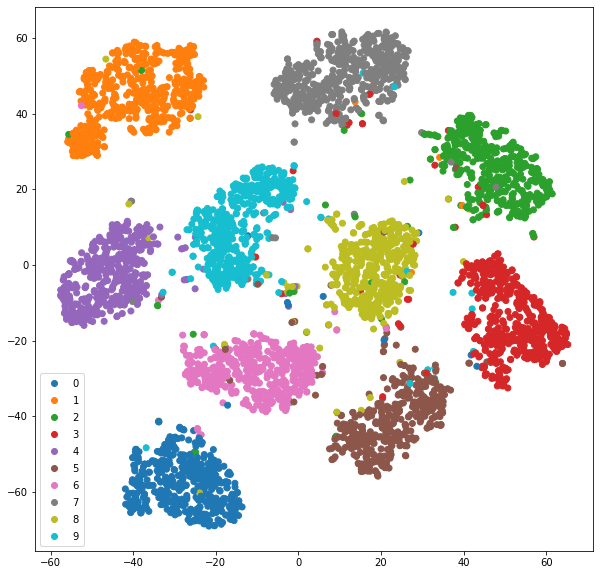

In [ ]:
intermediate_tsne_data = get_tsne(intermediates, n_images=N_IMAGES)
plot_representations(intermediate_tsne_data, labels, n_images=N_IMAGES)

In [ ]:
#The function below will repeatedly generate random noise and feed it through the model and find the most confidently generated digit for the desired class.
def imagine_digit(model, digit, device, n_iterations=50_000):

    model.eval()

    best_prob = 0
    best_image = None

    with torch.no_grad():

        for _ in trange(n_iterations):

            x = torch.randn(32, 28, 28).to(device)

            y_pred, _ = model(x)

            preds = F.softmax(y_pred, dim=-1)

            _best_prob, index = torch.max(preds[:, digit], dim=0)

            if _best_prob > best_prob:
                best_prob = _best_prob
                best_image = x[index]

    return best_image, best_prob

  0%|          | 0/50000 [00:00<?, ?it/s]

Best image probability: 99.98%


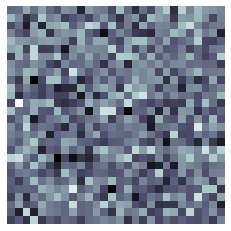

In [ ]:
DIGIT = 3

best_image, best_prob = imagine_digit(model, DIGIT, device)
print(f'Best image probability: {best_prob.item()*100:.2f}%')
plt.imshow(best_image.cpu().numpy(), cmap='bone')
plt.axis('off');

In [ ]:
#visualize weights
def plot_weights(weights, n_weights):

    rows = int(np.sqrt(n_weights))
    cols = int(np.sqrt(n_weights))

    fig = plt.figure(figsize=(20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(weights[i].view(28, 28).cpu().numpy(), cmap='bone')
        ax.axis('off')

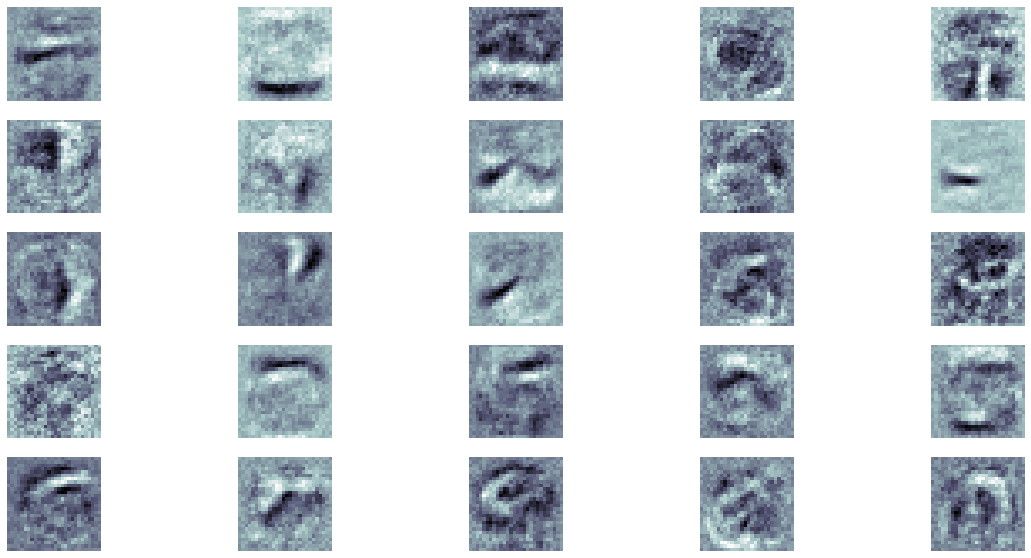

In [ ]:
#show weights
N_WEIGHTS = 25

weights = model.input_fc.weight.data

plot_weights(weights, N_WEIGHTS)